### Configuring cuDNN on Colab for YOLOv4


In [1]:
#@title CUDA LIBRARY DOWNLOAD
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it.
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

import os
os.environ['GPU_TYPE'] = str(os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read())

def getGPUArch(argument):
  try:
    argument = argument.strip()
    # All Colab GPUs
    archTypes = {
        "Tesla V100-SXM2-16GB": "-gencode arch=compute_70,code=[sm_70,compute_70]",
        "Tesla K80": "-gencode arch=compute_37,code=sm_37",
        "Tesla T4": "-gencode arch=compute_75,code=[sm_75,compute_75]",
        "Tesla P40": "-gencode arch=compute_61,code=sm_61",
        "Tesla P4": "-gencode arch=compute_61,code=sm_61",
        "Tesla P100-PCIE-16GB": "-gencode arch=compute_60,code=sm_60"

      }
    return archTypes[argument]
  except KeyError:
    return "GPU must be added to GPU Commands"
os.environ['ARCH_VALUE'] = getGPUArch(os.environ['GPU_TYPE'])

print("GPU Type: " + os.environ['GPU_TYPE'])
print("ARCH Value: " + os.environ['ARCH_VALUE'])

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Thu Feb 29 04:19:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  7

### Installing Darknet for YOLOv4 on Colab

In [2]:
#@title GIT CLONE DARKNET FOR YOLOv4
%cd /content/
%rm -rf darknet

# Clone the fork of darknet maintained by roboflow
!git clone https://github.com/AlexeyAB/darknet.git
# Install environment from the Makefile
%cd /content/darknet/

/content
Cloning into 'darknet'...
remote: Enumerating objects: 15833, done.
remote: Total 15833 (delta 0), reused 0 (delta 0), pack-reused 15833
Receiving objects: 100% (15833/15833), 14.39 MiB | 8.17 MiB/s, done.
Resolving deltas: 100% (10666/10666), done.
/content/darknet


In [3]:
#@title Installing Darknet for YOLOv4
%%capture
#install environment from the Makefile
#note if you are on Colab Pro this works on a P100 GPU
#if you are on Colab free, you may need to change the Makefile for the K80 GPU
#this goes for any GPU, you need to change the Makefile to inform darknet which GPU you are running on.
%cd /content/darknet/
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/g' Makefile
!sed -i "s/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= ${ARCH_VALUE}/g" Makefile
!make

### DOWNLOAD YOLO-TINY WEIGHTS

In [4]:
#@title Download weights
%%capture
#download the newly released yolov4-tiny weights
%cd /content/darknet
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29

### Upload Zip file containing Images and CSV file as train.zip

Link to the dataset used in this notebook: [**Chess Pieces Dataset**](https://public.roboflow.com/object-detection/chess-full/24)

**Note**: Download tensorflow object detection format

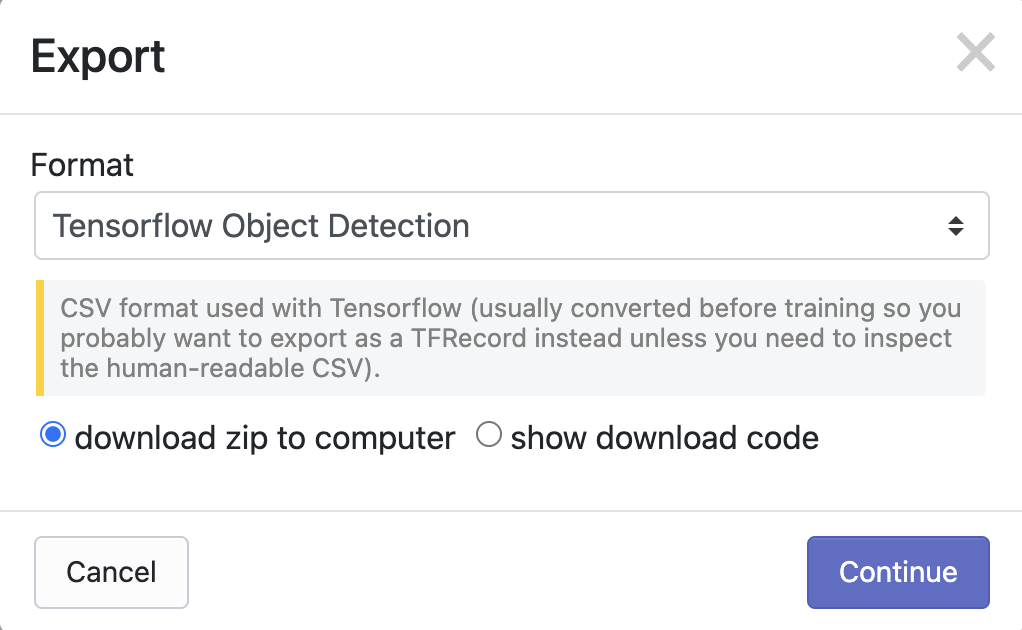

In [5]:
%cd /content/darknet/
%mkdir TrainingImages
%cd /content/darknet/TrainingImages/

/content/darknet
/content/darknet/TrainingImages


In [6]:
from google.colab import files
uploaded = files.upload()

Saving train.zip to train.zip


In [7]:
%%capture
!unzip train.zip

### Convert CSV to darknet txt format

In [8]:
%cd /content/darknet
import pandas as pd
from ast import literal_eval
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

train = pd.read_csv("/content/darknet/TrainingImages/train/_annotations.csv")
train.head()

/content/darknet


,filename,width,height,class,xmin,ymin,xmax,ymax
0,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,white-knight,170,233,200,303
1,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,white-king,46,80,81,169
2,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,white-queen,128,15,156,92
3,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,white-bishop,166,145,195,207
4,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,white-rook,162,31,189,86


In [9]:
train['class'] = pd.Categorical(train['class'])
train['class_cat'] = train['class'].cat.codes
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,class_cat
0,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,white-knight,170,233,200,303,9
1,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,white-king,46,80,81,169,8
2,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,white-queen,128,15,156,92,11
3,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,white-bishop,166,145,195,207,7
4,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,white-rook,162,31,189,86,12


In [10]:
d = dict(enumerate(train['class'].cat.categories))
print (d)

{0: 'bishop', 1: 'black-bishop', 2: 'black-king', 3: 'black-knight', 4: 'black-pawn', 5: 'black-queen', 6: 'black-rook', 7: 'white-bishop', 8: 'white-king', 9: 'white-knight', 10: 'white-pawn', 11: 'white-queen', 12: 'white-rook'}


In [11]:
del train['class']
train['bbox'] = train[train.columns[1:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
train.head()

,filename,width,height,xmin,ymin,xmax,ymax,class_cat,bbox
0,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,170,233,200,303,9,"416,416,170,233,200,303,9"
1,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,46,80,81,169,8,"416,416,46,80,81,169,8"
2,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,128,15,156,92,11,"416,416,128,15,156,92,11"
3,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,166,145,195,207,7,"416,416,166,145,195,207,7"
4,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,162,31,189,86,12,"416,416,162,31,189,86,12"


In [12]:
def bnd_box_to_yolo_line(coco_format_box):
  box = literal_eval(coco_format_box)
  x_min = box[2]
  x_max = box[4]
  y_min = box[3]
  y_max = box[5]

  w = box[0]
  h = box[1]

  x_center = float((x_min + x_max)) / 2 / w
  y_center = float((y_min + y_max)) / 2 / h

  w = float((x_max - x_min)) / w
  h = float((y_max - y_min)) / h

  class_index = box[6]

  #return x_center, y_center, w, h
  yolo_box = [class_index, x_center, y_center, w, h]
  return yolo_box

In [13]:
%%time
train['yolo_box'] = train.bbox.apply(bnd_box_to_yolo_line)

CPU times: user 89.4 ms, sys: 877 µs, total: 90.3 ms
Wall time: 91.2 ms


In [14]:
#Set up training file directories for custom dataset
%cd /content/darknet/
#Make obj dir which contains images & txt files
#Make obj1 dir which splits images into train & valid folder
%mkdir data/obj
%mkdir data/obj1

/content/darknet


In [15]:
train.head()

,filename,width,height,xmin,ymin,xmax,ymax,class_cat,bbox,yolo_box
0,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,170,233,200,303,9,"416,416,170,233,200,303,9","[9, 0.44471153846153844, 0.6442307692307693, 0..."
1,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,46,80,81,169,8,"416,416,46,80,81,169,8","[8, 0.15264423076923078, 0.29927884615384615, ..."
2,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,128,15,156,92,11,"416,416,128,15,156,92,11","[11, 0.34134615384615385, 0.12860576923076922,..."
3,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,166,145,195,207,7,"416,416,166,145,195,207,7","[7, 0.4338942307692308, 0.4230769230769231, 0...."
4,a8847f8fe8eaaa1c97bf83027a901760_jpg.rf.cb0f3b...,416,416,162,31,189,86,12,"416,416,162,31,189,86,12","[12, 0.421875, 0.140625, 0.06490384615384616, ..."


In [16]:
# Make txt files in data/obj folder
folder_location = "/content/darknet/data/obj"
train['filename'] = train['filename'].str.replace(r'.(?:jpg|png|jpeg)$', '')
unique_img_ids = train['filename'].unique()

for img_id in unique_img_ids:
    #print(img_id)
    filt_df = train.query("filename == @img_id") # filter the df to a specific id
    all_boxes = filt_df.yolo_box.values
    file_name = "{}/{}.txt".format(folder_location,img_id) # specify the name of the folder and get a file name

    s = "%d %s %s %s %s \n" # the first number is the identifier of the class.
    with open(file_name, 'a') as file: # append lines to file
        for i in all_boxes:
            new_line = (s % tuple(i))
            file.write(new_line)

<ipython-input-16-b78876b25e3e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train['filename'] = train['filename'].str.replace(r'.(?:jpg|png|jpeg)$', '')


In [17]:
# Copy from images training images folder into obj[needed by darknet model]
# and obj1[to make train.txt & valid.txt]

# Define source directory
source_dir = "TrainingImages/train/"

# Define destination directories
dest_dir_obj1 = "data/obj1/"
dest_dir_obj = "data/obj/"

# Create destination directories if they don't exist
os.makedirs(dest_dir_obj1, exist_ok=True)
os.makedirs(dest_dir_obj, exist_ok=True)

# Copy JPEG files
!cp {source_dir}*.jpg {dest_dir_obj1}
!cp {source_dir}*.jpg {dest_dir_obj}

# Copy PNG files
!cp {source_dir}*.png {dest_dir_obj1}
!cp {source_dir}*.png {dest_dir_obj}

# Copy JPEG files
!cp {source_dir}*.jpeg {dest_dir_obj1}
!cp {source_dir}*.jpeg {dest_dir_obj}

cp: cannot stat 'TrainingImages/train/*.png': No such file or directory
cp: cannot stat 'TrainingImages/train/*.png': No such file or directory
cp: cannot stat 'TrainingImages/train/*.jpeg': No such file or directory
cp: cannot stat 'TrainingImages/train/*.jpeg': No such file or directory


In [18]:
#Split obj1 images into train & valid folder
import glob
import random
import os
import shutil

# Get all paths to your images files and text files
PATH = '/content/darknet/data/obj1/'
types = ('*.png', '*.jpeg','*.jpg')
img_paths = []

for files in types:
    img_paths.extend(glob.glob(PATH+files))

# Calculate number of files for training, validation
data_size = len(img_paths)
r = 0.8
train_size = int(data_size * 0.8)

# Shuffle two list
random.seed(43)
random.shuffle(img_paths)

# Now split them
train_img_paths = img_paths[:train_size]

valid_img_paths = img_paths[train_size:]

# Move them to train, valid folders
train_folder = PATH+'train/'
valid_folder = PATH+'valid/'
os.mkdir(train_folder)
os.mkdir(valid_folder)

def move(paths, folder):
    for p in paths:
        shutil.move(p, folder)

move(train_img_paths, train_folder)
move(valid_img_paths, valid_folder)

In [19]:
print(len(train_img_paths))
print(len(valid_img_paths))

484
122


In [20]:
#Create obj.data file required for training darknet model
with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir('data/obj1/train') if f.endswith(('.png', '.jpg', '.jpeg'))]:
    out.write('data/obj/' + img + '\n')

with open('data/obj.names', 'w') as out:
  for key, value in d.items():
    out.write(value + '\n')
  out.truncate(out.tell()-1)

with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir('data/obj1/valid') if f.endswith(('.png', '.jpg', '.jpeg'))]:
    out.write('data/obj/' + img + '\n')

def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('data/obj.names')
with open('data/obj.data', 'w') as out:
  out.write('classes = ' + str(num_classes) + '\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = backup/')

In [21]:
#we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

num_classes = file_len('data/obj.names')
max_batches = 10000 #@param {type:"slider", min:0, max:100000, step:1000}
steps1 = .8 * max_batches
steps2 = .9 * max_batches
steps_str = str(steps1)+','+str(steps2)
num_filters = (num_classes + 5) * 3


print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

if os.path.exists('./cfg/custom-yolov4-tiny-detector.cfg'): os.remove('./cfg/custom-yolov4-tiny-detector.cfg')


#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

writing config for a custom YOLOv4 detector detecting number of classes: 13


### Set up Custom Config file for YOLOv4

In [22]:
%%capture
%%writetemplate ./cfg/custom-yolov4-tiny-detector.cfg
[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=24
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = {max_batches}
policy=steps
steps={steps_str}
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[route]
layers=-1
groups=2
group_id=1

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[route]
layers = -1,-2

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[route]
layers = -6,-1

[maxpool]
size=2
stride=2

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

##################################

[convolutional]
batch_normalize=1
filters=256
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=512
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
nms_kind=greedynms
beta_nms=0.6

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 23

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters={num_filters}
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes={num_classes}
num=6
jitter=.3
scale_x_y = 1.05
cls_normalizer=1.0
iou_normalizer=0.07
iou_loss=ciou
ignore_thresh = .7
truth_thresh = 1
random=0
nms_kind=greedynms
beta_nms=0.6

## Train Custom YOLOv4 Detector

In [ ]:
#Train Model
!./darknet detector train data/obj.data cfg/custom-yolov4-tiny-detector.cfg yolov4-tiny.conv.29 -dont_show -map

## Infer Custom Objects with Saved YOLOv4 Weights

In [25]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [26]:
#check if weigths have saved yet
#backup houses the last weights for our detector
#(file yolo-obj_last.weights will be saved to the build\darknet\x64\backup\ for each 100 iterations)
#(file yolo-obj_xxxx.weights will be saved to the build\darknet\x64\backup\ for each 1000 iterations)
#After training is complete - get result yolo-obj_final.weights from path build\darknet\x64\bac
!ls backup
#if it is empty you haven't trained for long enough yet, you need to train for at least 100 iterations

custom-yolov4-tiny-detector_last.weights


In [27]:
#coco.names is hardcoded somewhere in the detector
%cp data/obj.names data/coco.names

In [33]:
#/test has images that we can test our detector on
test_images = [f for f in os.listdir('/content/darknet/data/obj') if f.endswith('.jpg')]
import random
img_path = "/content/darknet/data/obj/" + random.choice(test_images);

#test out our detector!
!./darknet detect cfg/custom-yolov4-tiny-detector.cfg backup/custom-yolov4-tiny-detector_last.weights {img_path} -dont-show

 CUDA-version: 12020 (12020), cuDNN: 8.9.6, GPU count: 1  
 OpenCV version: 4.5.4
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 24, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  10

In [31]:
img_path

'/content/darknet/data/obj/7ee8d13861bdc45e40a7cfe190a8d8a6_jpg.rf.a8231ed0a104c2558156dc1efa5deaa4.jpg'

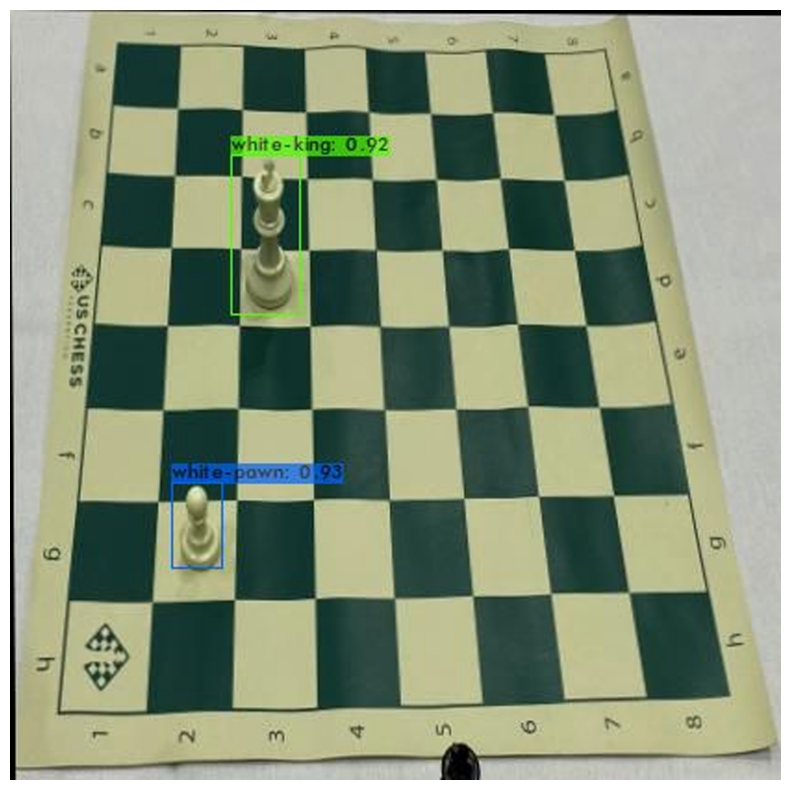

In [34]:
imShow('/content/darknet/predictions.jpg')

# Download Custom-Model folder

In [44]:
%cd /content
!mkdir "/content/custom_model"
!cp "/content/darknet/cfg/custom-yolov4-tiny-detector.cfg" "/content/custom_model"
!cp "/content/darknet/data/obj.names" "/content/custom_model"
!cp "/content/darknet/backup/custom-yolov4-tiny-detector_last.weights" "/content/custom_model"

%cd /content/custom_model/
os.rename("custom-yolov4-tiny-detector.cfg","obj.cfg")
os.rename("custom-yolov4-tiny-detector_last.weights","obj.weights")
!zip -r /content/custom_model.zip /content/custom_model

/content/custom_model
updating: content/custom_model/ (stored 0%)
updating: content/custom_model/obj.weights (deflated 7%)
updating: content/custom_model/obj.names (deflated 52%)
updating: content/custom_model/obj.cfg (deflated 81%)
